I wanted to see if making the threshold and multi params tuneable would have an effect by making the erelu function differentiable to solve the hyperparameter tuning issue. While there is a lower loss in some senarios, it's a lot worse in others, and the parameters that you end up with don't fit into your intuition for how the threshold should be set as something larger than 0 sometimes.

In [44]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
device = torch.device("mps")

#### NOTE: I've added some transforms here to increase the sparsity of the features.
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Resize((56, 56)),
    transforms.RandomAffine(degrees=0, translate=(0.4, 0.4), scale=(0.3, 0.3))
    ])

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [45]:
# Create training and test dataloaders

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20


train_data, val_data = torch.utils.data.random_split(train_data, (0.9, 0.1))

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [74]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, in_dim, encoding_dim, act=nn.ReLU):
        super(Autoencoder, self).__init__()
        ## encoder ##
        self.encoder = nn.Linear(in_dim, encoding_dim)
        ## decoder ##
        self.decoder = nn.Linear(encoding_dim, in_dim)
        self.act = act()

    def forward(self, x):
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function
        
        # pass x into encoder
        out = self.encoder(x)
        # pass out into decoder
        out = self.act(self.decoder(out))
        
        return out

In [75]:
def train(n_epochs=20):
    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0
        val_loss = 0.0
        
        ###################
        # train the model #
        ###################
        for data in train_loader:
            # _ stands in for labels, here
            images, _ = data
            # flatten images
            images = images.view(images.size(0), -1).to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs, images)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*images.size(0)
                
        # print avg training statistics 
        with torch.no_grad():
            for data in val_loader:
                images, _ = data
                # flatten images
                images = images.view(images.size(0), -1).to(device)
                # forward pass: compute predicted outputs by passing inputs to the model
                outputs = model(images)
                # calculate the loss
                loss = criterion(outputs, images)
                # update running training loss
                val_loss += loss.item()*images.size(0)
                
        train_loss = train_loss/len(train_loader)
        val_loss = val_loss/len(val_loader)
        print('Epoch: {} \tTraining Loss: {:.6f}, Validation loss: {:.6f}'.format(
            epoch, 
            train_loss,
            val_loss
            ))

## Testing different activations

In [83]:
class EReluOriginal(nn.Module):
    def __init__(self):
        super().__init__()
        self.threshold = 0.3
        self.multi = 0.05

    def forward(self, features):
        mask = features >= self.threshold
    
        mask = mask + self.multi
        # mask = torch.sigmoid((features - self.threshold) * 1000) + self.multi
        return features * mask

In [84]:
class EReluMultiDifferentiable(nn.Module):
    def __init__(self):
        super().__init__()
        self.threshold = 0.3
        self.multi = nn.Parameter(torch.tensor(0.0))

    def forward(self, features):
        # mask = features >= self.threshold
    
        # mask = mask + self.multi
        mask = torch.sigmoid((features - self.threshold) * 1000) + self.multi
        return features * mask

In [85]:
class EReluDifferentiable(nn.Module):
    def __init__(self):
        super().__init__()
        self.threshold = nn.Parameter(torch.tensor(0.5))
        self.multi = nn.Parameter(torch.tensor(0.05))

    def forward(self, features):
        # mask = features >= self.threshold
    
        # mask = mask + self.multi
        mask = torch.sigmoid((features - self.threshold) * 1000) + self.multi
        return features * mask

In [86]:
# specify loss function
criterion = nn.MSELoss()
encoding_dim = 32
acts = [nn.ReLU, EReluOriginal, EReluMultiDifferentiable, EReluDifferentiable]

for i, act in enumerate(acts):
    print("=================================================")
    print(f"Starting training using {act}")
    model = Autoencoder(28 ** 2, encoding_dim, act=act).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train(n_epochs=30)
    if i > 0:
        print(f"Threshold: {model.act.threshold}, Multi: {model.act.multi}")

Starting training using <class 'torch.nn.modules.activation.ReLU'>
Epoch: 1 	Training Loss: 0.123285, Validation loss: 0.102939
Epoch: 2 	Training Loss: 0.101075, Validation loss: 0.099521
Epoch: 3 	Training Loss: 0.099104, Validation loss: 0.098636
Epoch: 4 	Training Loss: 0.098065, Validation loss: 0.097692
Epoch: 5 	Training Loss: 0.097766, Validation loss: 0.097284
Epoch: 6 	Training Loss: 0.096871, Validation loss: 0.097809
Epoch: 7 	Training Loss: 0.096860, Validation loss: 0.097332
Epoch: 8 	Training Loss: 0.096639, Validation loss: 0.097690
Epoch: 9 	Training Loss: 0.096390, Validation loss: 0.096349
Epoch: 10 	Training Loss: 0.096298, Validation loss: 0.095853
Epoch: 11 	Training Loss: 0.096085, Validation loss: 0.095791
Epoch: 12 	Training Loss: 0.095839, Validation loss: 0.096526
Epoch: 13 	Training Loss: 0.095814, Validation loss: 0.095840
Epoch: 14 	Training Loss: 0.095430, Validation loss: 0.096235
Epoch: 15 	Training Loss: 0.095361, Validation loss: 0.095458
Epoch: 16 	T

In [87]:
# specify loss function
criterion = nn.MSELoss()
encoding_dim = 16 
acts = [nn.ReLU, EReluOriginal, EReluMultiDifferentiable, EReluDifferentiable]

for i, act in enumerate(acts):
    print("=================================================")
    print(f"Starting training using {act}")
    model = Autoencoder(28 ** 2, encoding_dim, act=act).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train(n_epochs=30)
    if i > 0:
        print(f"Threshold: {model.act.threshold}, Multi: {model.act.multi}")

Starting training using <class 'torch.nn.modules.activation.ReLU'>
Epoch: 1 	Training Loss: 0.154884, Validation loss: 0.135342
Epoch: 2 	Training Loss: 0.131473, Validation loss: 0.129559
Epoch: 3 	Training Loss: 0.128098, Validation loss: 0.128563
Epoch: 4 	Training Loss: 0.126572, Validation loss: 0.126149
Epoch: 5 	Training Loss: 0.125935, Validation loss: 0.125948
Epoch: 6 	Training Loss: 0.125202, Validation loss: 0.125208
Epoch: 7 	Training Loss: 0.124767, Validation loss: 0.124205
Epoch: 8 	Training Loss: 0.124684, Validation loss: 0.123974
Epoch: 9 	Training Loss: 0.124010, Validation loss: 0.123477
Epoch: 10 	Training Loss: 0.123707, Validation loss: 0.123874
Epoch: 11 	Training Loss: 0.123393, Validation loss: 0.123210
Epoch: 12 	Training Loss: 0.123309, Validation loss: 0.122787
Epoch: 13 	Training Loss: 0.123049, Validation loss: 0.122545
Epoch: 14 	Training Loss: 0.123212, Validation loss: 0.123577
Epoch: 15 	Training Loss: 0.123048, Validation loss: 0.122706
Epoch: 16 	T

In [88]:
# specify loss function
criterion = nn.MSELoss()
encoding_dim = 8
acts = [nn.ReLU, EReluOriginal, EReluMultiDifferentiable, EReluDifferentiable]

for i, act in enumerate(acts):
    print("=================================================")
    print(f"Starting training using {act}")
    model = Autoencoder(28 ** 2, encoding_dim, act=act).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train(n_epochs=30)
    if i > 0:
        print(f"Threshold: {model.act.threshold}, Multi: {model.act.multi}")

Starting training using <class 'torch.nn.modules.activation.ReLU'>
Epoch: 1 	Training Loss: 0.187315, Validation loss: 0.167991
Epoch: 2 	Training Loss: 0.163608, Validation loss: 0.161262
Epoch: 3 	Training Loss: 0.159659, Validation loss: 0.158089
Epoch: 4 	Training Loss: 0.157438, Validation loss: 0.157051
Epoch: 5 	Training Loss: 0.156656, Validation loss: 0.156938
Epoch: 6 	Training Loss: 0.155719, Validation loss: 0.155952
Epoch: 7 	Training Loss: 0.155388, Validation loss: 0.155199
Epoch: 8 	Training Loss: 0.154802, Validation loss: 0.155102
Epoch: 9 	Training Loss: 0.154720, Validation loss: 0.154392
Epoch: 10 	Training Loss: 0.154101, Validation loss: 0.154671
Epoch: 11 	Training Loss: 0.153942, Validation loss: 0.153943
Epoch: 12 	Training Loss: 0.153944, Validation loss: 0.154420
Epoch: 13 	Training Loss: 0.153828, Validation loss: 0.154443
Epoch: 14 	Training Loss: 0.153627, Validation loss: 0.154218
Epoch: 15 	Training Loss: 0.153685, Validation loss: 0.153910
Epoch: 16 	T

In [52]:
encoding_dim = 32
model = Autoencoder(28 ** 2, encoding_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train(n_epochs=50)

Epoch: 1 	Training Loss: 0.128804, Validation loss: 0.105401
Epoch: 2 	Training Loss: 0.097993, Validation loss: 0.091186
Epoch: 3 	Training Loss: 0.087005, Validation loss: 0.082441
Epoch: 4 	Training Loss: 0.078028, Validation loss: 0.075853
Epoch: 5 	Training Loss: 0.072288, Validation loss: 0.069928
Epoch: 6 	Training Loss: 0.067487, Validation loss: 0.065449
Epoch: 7 	Training Loss: 0.062482, Validation loss: 0.061829
Epoch: 8 	Training Loss: 0.058565, Validation loss: 0.056028
Epoch: 9 	Training Loss: 0.054706, Validation loss: 0.053344
Epoch: 10 	Training Loss: 0.051430, Validation loss: 0.049412
Epoch: 11 	Training Loss: 0.047957, Validation loss: 0.045651
Epoch: 12 	Training Loss: 0.044483, Validation loss: 0.043769
Epoch: 13 	Training Loss: 0.042253, Validation loss: 0.040788
Epoch: 14 	Training Loss: 0.039294, Validation loss: 0.037422
Epoch: 15 	Training Loss: 0.037521, Validation loss: 0.037331
Epoch: 16 	Training Loss: 0.035124, Validation loss: 0.032935
Epoch: 17 	Traini

## Checking out the results

Below I've plotted some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

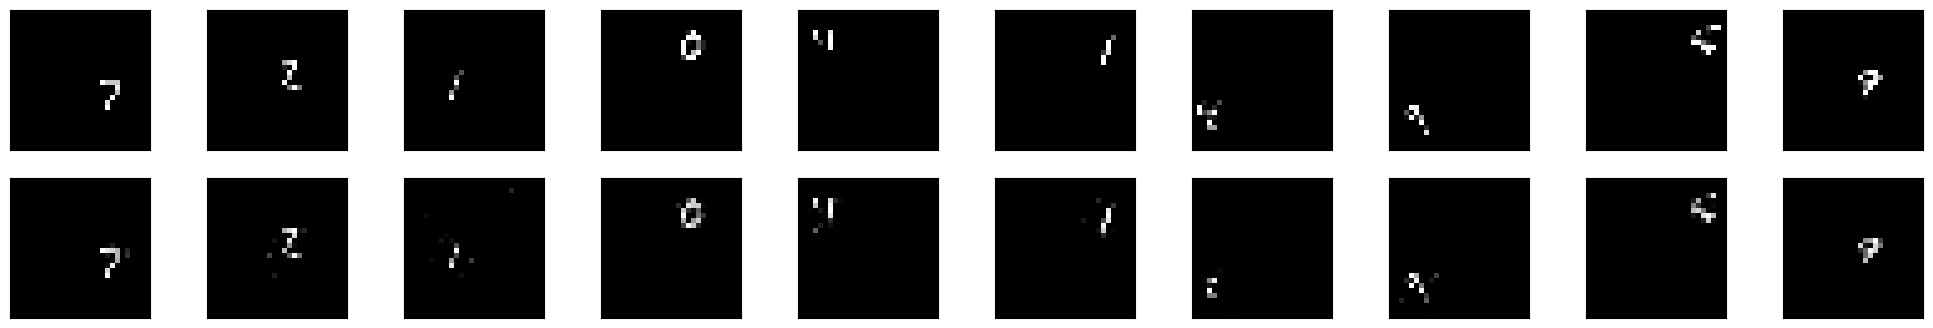

In [56]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

images_flatten = images.view(images.size(0), -1).to(device)
# get sample outputs
output = model(images_flatten)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)